In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import time
import basicFunctions as bf
import pickle

### Colorblind friendly colors:

colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [213/255,94/255,0], [0,114/255,178/255]]


import matplotlib.style
import matplotlib as mpl
mpl.style.use('fivethirtyeight')
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 15}
mpl.rc('font', **font)


import BNNUtils as bu

import os
import sys

path = os.getcwd()

In [2]:

@variational_estimator
class BayesianRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        #self.linear = nn.Linear(input_dim, output_dim)
        self.blinear1 = BayesianLinear(input_dim, 80)
        self.blinear2 = BayesianLinear(80, 60)
        self.blinear3 = BayesianLinear(60, 50)
        self.blinear4 = BayesianLinear(50, 40)
        self.blinear5 = BayesianLinear(40, 20)
        self.blinear6 = BayesianLinear(20, 20)
        self.blinear7 = BayesianLinear(20, 20)
        self.blinear8 = BayesianLinear(20, output_dim)
        
    def forward(self, x):
        x_ = self.blinear1(x)
        x_=self.blinear2(x_)
        x_=self.blinear3(x_)
        x_=self.blinear4(x_)
        x_=self.blinear5(x_)
        x_=self.blinear6(x_)
        x_=self.blinear7(x_)
        return self.blinear8(x_)   

def evaluate_regression(regressor,
                        X,
                        y,
                        samples = 100,
                        std_multiplier = 2):
    preds = [regressor(X) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0)
    stds = preds.std(axis=0)
    ci_upper = means + (std_multiplier * stds)
    ci_lower = means - (std_multiplier * stds)
    ic_acc = (ci_lower <= y) * (ci_upper >= y)
    ic_acc = ic_acc.float().mean()
    return ic_acc, (ci_upper >= y).float().mean(), (ci_lower <= y).float().mean()


def calc_mse_and_mae(meas, pred):
    mse = np.mean((meas - pred)**2)
    mae = np.mean(np.abs(meas-pred))
    return mse, mae

In [3]:
PATH = path+"/../datasets/"
NAME = "compiled_"
inputdf = pd.read_csv(PATH + NAME +'X.csv') 
outputdf = pd.read_csv(PATH + NAME + 'Y.csv') 

In [4]:
variable_names = inputdf.columns[1:]

output_names = outputdf.columns[1:]

view = False
name_dict = {}
## View the names and indicies of each variable
for i, v in enumerate(variable_names):
    name_dict[v] = i
    if view:
        print(i, v)
        


Original shape of data, before cutting out extraneous data or selected HXR samples:
Input values: (286923, 77)
Output values: (286923,)
Removed 0.646515% of full dataset, eliminating extraneous values
Final shape of data, after cutting out extraneous data:
Input values: (285068, 76)
Output values: (285068,)


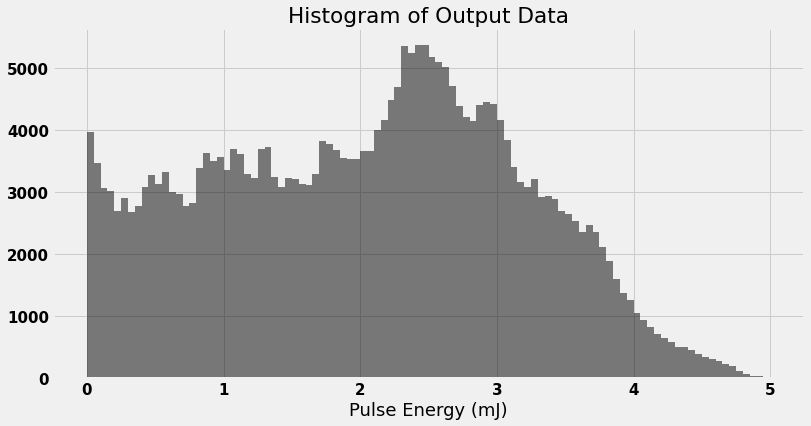

In [5]:
input_data = inputdf.to_numpy()
output_data = outputdf.to_numpy()
## Removing "index column"
output_data = output_data[:,1]


print("Original shape of data, before cutting out extraneous data or selected HXR samples:")
print("Input values: " + str(np.shape(input_data)))
print("Output values: " + str(np.shape(output_data)))

mask = np.where(np.logical_and(output_data>0, output_data<5))

## apply mask and cut out "index column"

removed_perc = 100*(np.shape(output_data)[0] - np.shape(output_data[mask])[0])/(np.shape(output_data)[0] )

input_data = input_data[mask[0], 1:]
output_data = output_data[mask]

print("Removed {:2f}% of full dataset, eliminating extraneous values".format(removed_perc))



print("Final shape of data, after cutting out extraneous data:")
print("Input values: " + str(np.shape(input_data)))
print("Output values: " + str(np.shape(output_data)))

plt.figure(figsize = (12,6))
plt.title("Histogram of Output Data")
plt.xlabel("Pulse Energy (mJ)")
plt.hist(output_data, 100, facecolor = colors[0], alpha = 0.5)
plt.show()

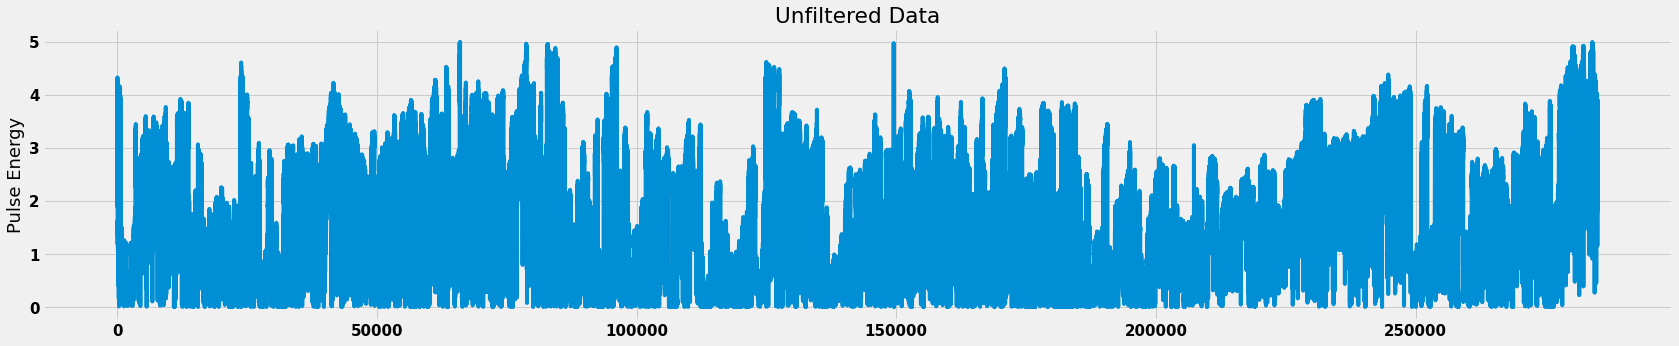

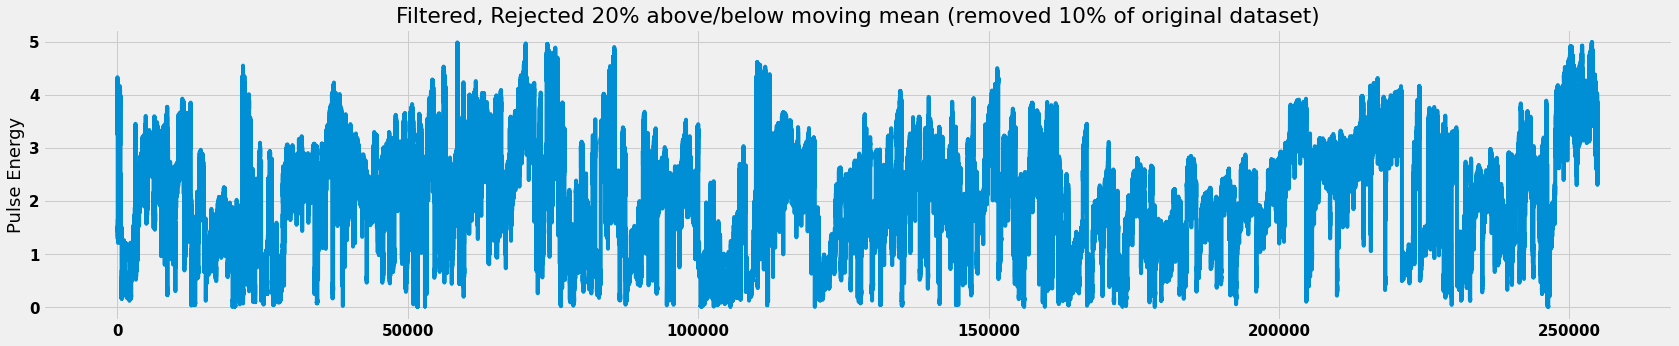

In [6]:
input_data = np.load("20perc_inputs.npy")
out_data = np.load("20perc_outputs.npy")

n = np.shape(input_data)[0]


plt.figure(figsize = (26, 5))
plt.title("Unfiltered Data")
plt.ylabel("Pulse Energy")
plt.plot(output_data)
plt.show()

plt.figure(figsize = (26, 5))
plt.title("Filtered, Rejected 20% above/below moving mean (removed 10% of original dataset)")
plt.ylabel("Pulse Energy")
plt.plot(out_data)
plt.show()

In [7]:
output_data = out_data

In [8]:
import QuantRegUtils as qru 
PATH = os.path.join(path + "/../models/BNN/")
MODEL_NAME = ""
loading = False
if loading:
    x_scales = np.load(PATH + MODEL_NAME + "x_scales.npy")
    x_offsets = np.load(PATH + MODEL_NAME + "x_offsets.npy")
    y_scale = np.load(PATH + MODEL_NAME + "y_scale.npy")
    y_offset = np.load(PATH + MODEL_NAME + "y_offset.npy")
    x_scaled = np.load(PATH + MODEL_NAME + "x_scaled.npy")
    y_scaled = np.load(PATH + MODEL_NAME + "y_scaled.npy")
else:
    x_scaled, x_scales, x_offsets = bf.do_scaling(input_data, -1, 1)
    y_offset, y_scale= bf.get_scale(output_data)

    y_scaled = bf.scale_data(output_data, y_offset, y_scale, -1,1)
    
    np.save(PATH + MODEL_NAME + "x_scales.npy", x_scales)
    np.save(PATH + MODEL_NAME + "x_offsets.npy", x_offsets)
    np.save(PATH + MODEL_NAME + "y_scale.npy", y_scale)
    np.save(PATH + MODEL_NAME + "y_offset.npy", y_offset)
    np.save(PATH + MODEL_NAME + "x_scaled.npy", x_scaled)
    np.save(PATH + MODEL_NAME + "y_scaled.npy", y_scaled)

x, y, scd = qru.scaling_and_dict(input_data, output_data)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x, y[:,np.newaxis], test_size=0.2, random_state=42)

input_dict = {}
input_dict["train"] = X_train
input_dict["test"] = X_test

output_dict = {}
output_dict["train"] = y_train
output_dict["test"] = y_test

with open(PATH + "inputs.pkl", 'wb') as f:
    pickle.dump(input_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(PATH + "outputs.pkl", 'wb') as f:
    pickle.dump(output_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
    
X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()



In [14]:
SAVEPATH = PATH 

LR = 0.01
LR0 = LR
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
regressor = BayesianRegressor(76, 1).to(device)
optimizer = optim.Adam(regressor.parameters(), lr = LR)
criterion = torch.nn.MSELoss()


ds_train = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=2048, shuffle=True)

ds_test = torch.utils.data.TensorDataset(X_test, y_test)
dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=2048, shuffle=True)


CI = []
CIU = []
CIL = []
LRs = []

start = time.time()
iteration = 0
print("Started Training")
for epoch in range(400):
    
    if epoch%25==0:
        LR = LR*0.75
        LRs.append(LR)
        optimizer = optim.Adam(regressor.parameters(), lr = LR)
        print("Learning rate = " + str(LR))
    
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        loss = regressor.sample_elbo(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion,
                           sample_nbr=3,
                           complexity_cost_weight=1/X_train.shape[0])
        loss.backward()
        optimizer.step()
        
        iteration += 1
        if iteration%100==0:
            print("Epoch: " + str(epoch))
            ic_acc, under_ci_upper, over_ci_lower = evaluate_regression(regressor,
                                                                        X_test.to(device),
                                                                        y_test.to(device),
                                                                        samples=100,
                                                                        std_multiplier=2)
            CI.append(ic_acc)
            CIU.append(under_ci_upper)
            CIL.append(over_ci_lower)
            print("CI acc: {:.4f}, CI upper acc: {:.4f}, CI lower acc: {:.4f}".format(ic_acc, under_ci_upper, over_ci_lower))
    
stop = time.time()
ic_acc, under_ci_upper, over_ci_lower = evaluate_regression(regressor,
                                                            X_test.to(device),
                                                            y_test.to(device),
                                                            samples=100,
                                                            std_multiplier=2) 
print("-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_")
print("Final Coverage and Loss")
print("CI acc: {:.4f}, CI upper acc: {:.4f}, CI lower acc: {:.4f}".format(ic_acc, under_ci_upper, over_ci_lower))
print("Loss: {:.4f}".format(loss))
print("Time to Complete = {:.2f} minutes".format(((stop-start)/3600)))
print("-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_")

ci = np.array(CI)
ciu = np.array(CIU)
cil = np.array(CIL)

plt.figure(figsize = (16,9))
plt.plot(100*ci, 'k', label = 'CI accuracy')
plt.plot(100*ciu, 'r', label = 'CIUpper accuracy')
plt.plot(100*cil, 'g', label = 'CILower accuracy')
plt.plot(100*(LR/LR0), '.', label = 'LR')
plt.ylabel("Percent Accuracy")
plt.legend()
plt.show()




Started Training
Learning rate = 0.0075
Epoch: 0
CI acc: 0.0185, CI upper acc: 0.5401, CI lower acc: 0.4784
Epoch: 1
CI acc: 0.0272, CI upper acc: 0.4058, CI lower acc: 0.6214
Epoch: 2
CI acc: 0.0312, CI upper acc: 0.3768, CI lower acc: 0.6545
Epoch: 3
CI acc: 0.0467, CI upper acc: 0.4780, CI lower acc: 0.5688
Epoch: 4
CI acc: 0.0537, CI upper acc: 0.4925, CI lower acc: 0.5611
Epoch: 5
CI acc: 0.0593, CI upper acc: 0.4119, CI lower acc: 0.6474
Epoch: 6
CI acc: 0.0807, CI upper acc: 0.5618, CI lower acc: 0.5189
Epoch: 7
CI acc: 0.1040, CI upper acc: 0.5784, CI lower acc: 0.5256
Epoch: 8
CI acc: 0.1050, CI upper acc: 0.4938, CI lower acc: 0.6113
Epoch: 9
CI acc: 0.1151, CI upper acc: 0.5129, CI lower acc: 0.6022
Epoch: 10
CI acc: 0.1274, CI upper acc: 0.5286, CI lower acc: 0.5987
Epoch: 11
CI acc: 0.1328, CI upper acc: 0.5333, CI lower acc: 0.5995
Epoch: 12
CI acc: 0.1620, CI upper acc: 0.5954, CI lower acc: 0.5666
Epoch: 13
CI acc: 0.1988, CI upper acc: 0.6687, CI lower acc: 0.5302
Epoc

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/global/homes/l/lgupta/.conda/envs/felblitz/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-1784d508cdb7>", line 42, in <module>
    loss.backward()
  File "/global/homes/l/lgupta/.conda/envs/felblitz/lib/python3.6/site-packages/torch/tensor.py", line 195, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph)
  File "/global/homes/l/lgupta/.conda/envs/felblitz/lib/python3.6/site-packages/torch/autograd/__init__.py", line 99, in backward
    allow_unreachable=True)  # allow_unreachable flag
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/global/homes/l/lgupta/.conda/envs/felblitz/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeEr

TypeError: object of type 'NoneType' has no len()

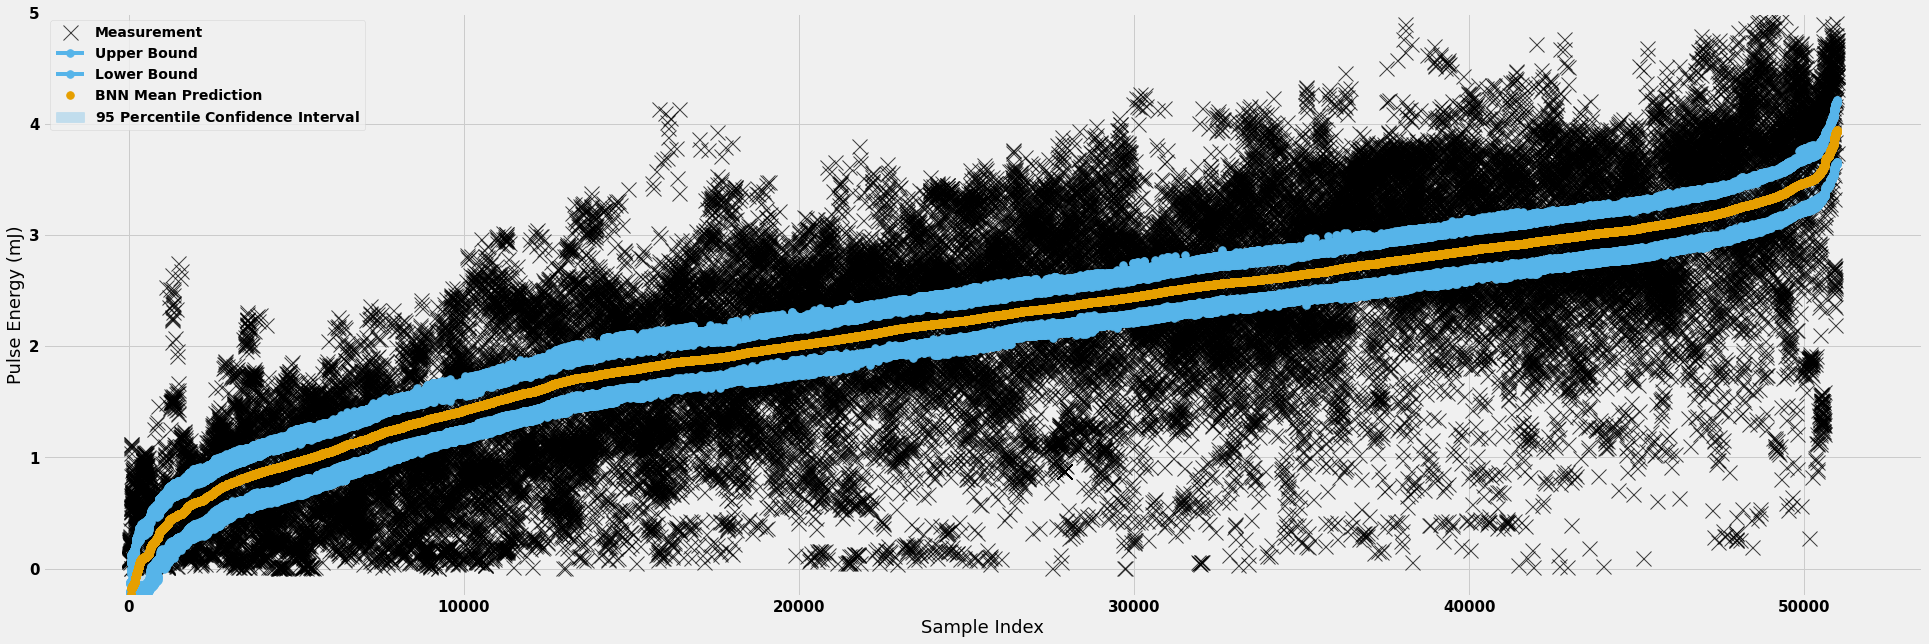

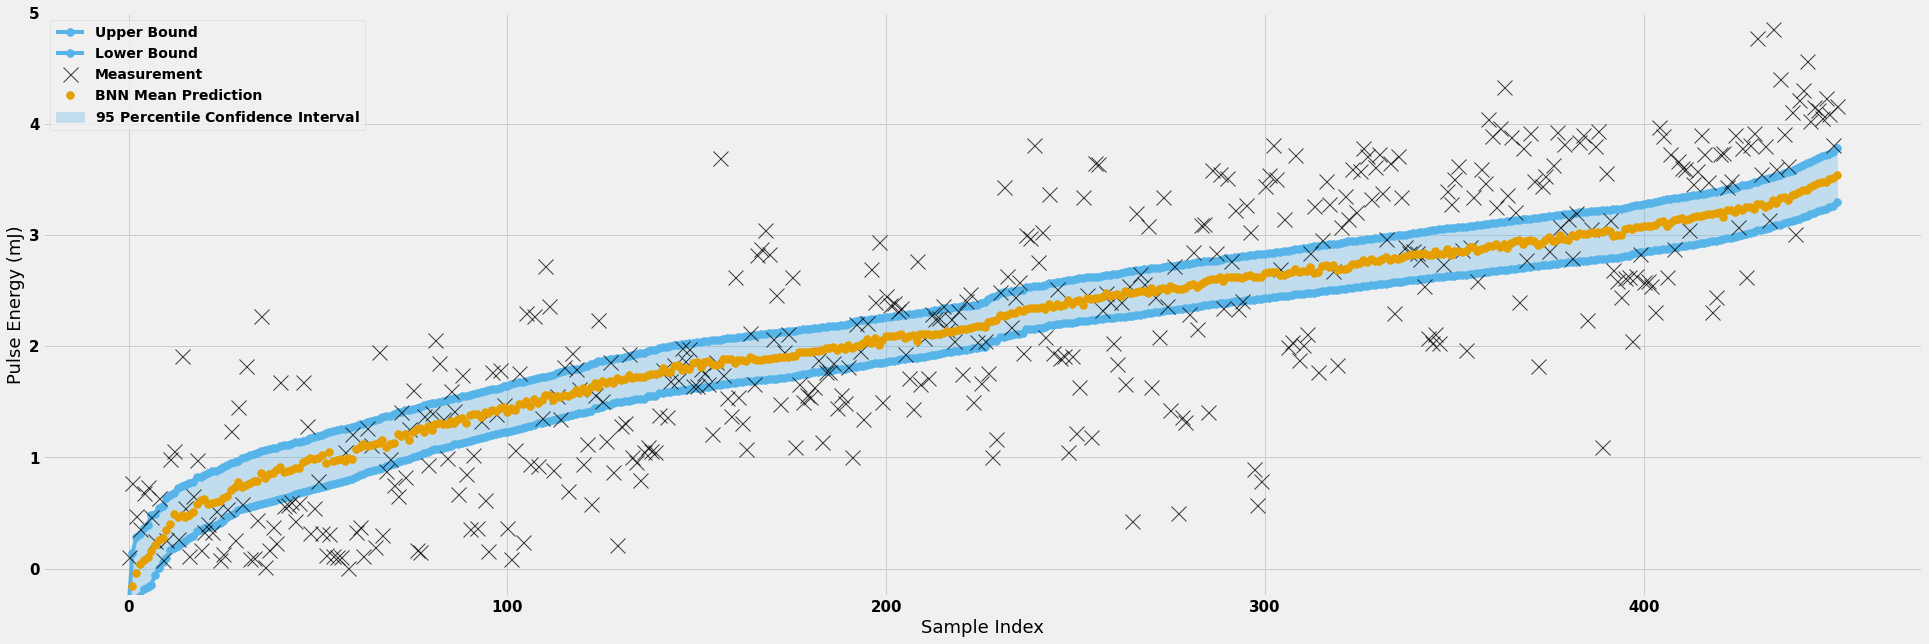

MSE = 0.44
MAE = 0.52


In [11]:
num=100
tempnum=y_test.shape[0]
preds=np.zeros((tempnum,num))
for i in range(num):
    temp=regressor.forward(X_test)
    pred1=temp.detach().numpy()
    preds[:,i]=pred1[:,0]
tempmean=np.mean(preds,axis=1)

tempstd=np.std(preds,axis=1)
tempmean.shape,tempstd.shape
tempmedian=np.quantile(preds,0.5,axis=1)
temp075=np.quantile(preds,0.975,axis=1)
temp025=np.quantile(preds,0.025,axis=1)


yreals = bf.unscale_data(y_test, y_offset, y_scale, -1, 1)
ymedian=bf.unscale_data(tempmedian[:,np.newaxis], y_offset, y_scale, -1, 1)
yu=bf.unscale_data(temp075[:,np.newaxis], y_offset, y_scale, -1, 1)
yl=bf.unscale_data(temp025[:,np.newaxis], y_offset, y_scale, -1, 1)


idx=np.argsort(ymedian[:,0])
base=np.arange(len(idx))
lower=yl[idx,0]
upper=yu[idx,0]

markersize = 15
plt.figure(figsize=(30,10))
#plt.title("BNN Results: Uncertainty Estimates and Mean Prediction for FEL Pulse Energy")
plt.plot(yreals[idx,0],'x', color = colors[0], alpha = 0.75, markersize = markersize, label= "Measurement")
plt.plot(yu[idx,0],'.-', color = colors[2], markersize = markersize,label = "Upper Bound")
plt.plot(yl[idx,0],'.-', color = colors[2], markersize = markersize,label = "Lower Bound")
plt.plot(ymedian[idx,0],'.', color = colors[1],markersize = markersize,label= "BNN Mean Prediction")
plt.fill_between(base,lower,upper,color = colors[2], alpha=0.3,label="$95$ Percentile Confidence Interval") 
plt.ylim(-0.25,5)
plt.xlabel('Sample Index')
plt.ylabel('Pulse Energy (mJ)')
plt.legend(prop={'size': 14})
#plt.savefig("BNN-test-sortedmed2.png")
plt.show()


lbinds = np.argsort(yl[:,0])
ubinds = np.argsort(yu[:,0])

n = 500
seq = []
step = int(yu.shape[0]/n)

for i in range(n):
        temp1=lbinds[i*step:(i+1)*step]
        temp2=ubinds[i*step:(i+1)*step]
        for num in temp1:
            if(num in temp2):
                seq.append(num)
                break
                

base=np.arange(len(seq))
lower=yl[seq,0]
upper=yu[seq,0]

plt.figure(figsize=(30,10))
#plt.title("BNN Results Mean Prediction and Uncertainty Estimates for FEL Pulse Energy, For Data Test Set Only")
plt.plot(yu[seq,0],'.-', color = colors[2], markersize = markersize,label = "Upper Bound")
plt.plot(yl[seq,0],'.-', color = colors[2], markersize = markersize,label = "Lower Bound")

plt.plot(yreals[seq,0],'x', color = colors[0], alpha = 0.75, markersize = markersize,label= "Measurement")
plt.plot(ymedian[seq,0],'.', color = colors[1],markersize = markersize,label= "BNN Mean Prediction")

plt.fill_between(base,lower,upper, color = colors[2], alpha=0.3,label="$95$ Percentile Confidence Interval") 

plt.xlabel('Sample Index')
plt.ylabel('Pulse Energy (mJ)')
plt.legend(prop={'size': 14})
plt.ylim(-0.25,5)
#plt.savefig("BNN-test-sortedseq2.png")
plt.show()

mse, mae = calc_mse_and_mae(yreals.detach().numpy(), ymedian)
print("MSE = {:2.2f}".format(mse))
print("MAE = {:2.2f}".format(mae))

torch.save(regressor.state_dict(), SAVEPATH + "BNN_model2.h5")